# Twitter Hate Speech Detection

In this project, we will be using some of the tools we have used throughout the course to analyze and classify text data to see if they can be used to detect hate speech on Twitter or at least tell the difference between hate speech and non-hate speech. We will also check to see how accurate they are in classifying the tweets as well as see what could be causing issues in the classification process.

data source: https://huggingface.co/datasets/viewer/?dataset=tweets_hate_speech_detection

In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

First, let's create two word clouds, one to represent non-hate speech and another to represent hate speech. This way we can get an idea of what words are most used and therefore define each category of tweets.

# WORD CLOUD

Load the data

In [2]:
df = pd.read_csv('train_tweet.csv')

In [3]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if t.is_alpha]

Tokenize the data (this removes "@user" and meaningless symbol characters)

In [4]:
import multiprocessing as mp

In [5]:
with mp.Pool() as p:
    df["tokens"] = list(p.imap(tokenize, tqdm(df["tweet"]), chunksize=100))

  0%|          | 0/31962 [00:00<?, ?it/s]

In [6]:
df

,id,label,tweet,tokens
0,1,0,@user when a father is dysfunctional and is s...,"[when, a, father, is, dysfunctional, and, is, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,"[thanks, for, lyft, credit, i, can, use, cause..."
2,3,0,bihday your majesty,"[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,"[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,"[factsguide, society, now, motivation]"
...,...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...,"[ate, isz, that]"
31958,31959,0,to see nina turner on the airwaves trying to...,"[to, see, nina, turner, on, the, airwaves, try..."
31959,31960,0,listening to sad songs on a monday morning otw...,"[listening, to, sad, songs, on, a, monday, mor..."
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...","[sikh, temple, vandalized, in, in, calgary, ws..."


Split the data into non-hate speech (label = 0) and hate speech (label = 1)

In [7]:
df0 = df[df['label'] == 0]
df1 = df[df['label'] == 1]

Generate word cloud for non-hate speech tweets

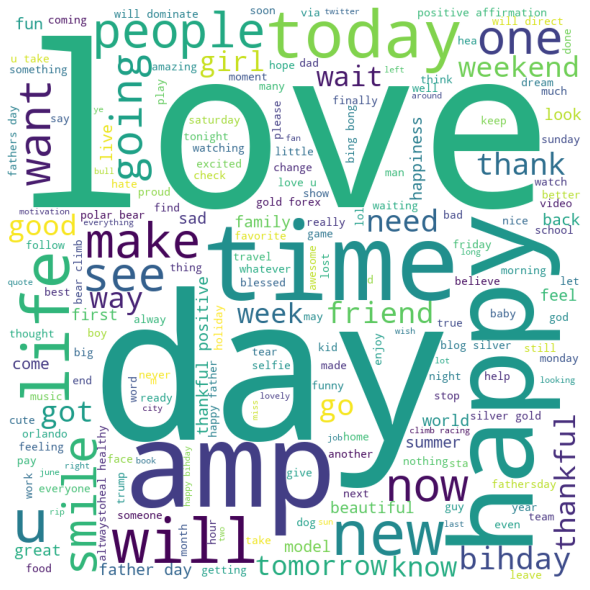

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
  
comment_words = ''
stopwords = set(STOPWORDS)
  
for tokens in df0.tokens:

    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

Generate word cloud for hate speech tweets

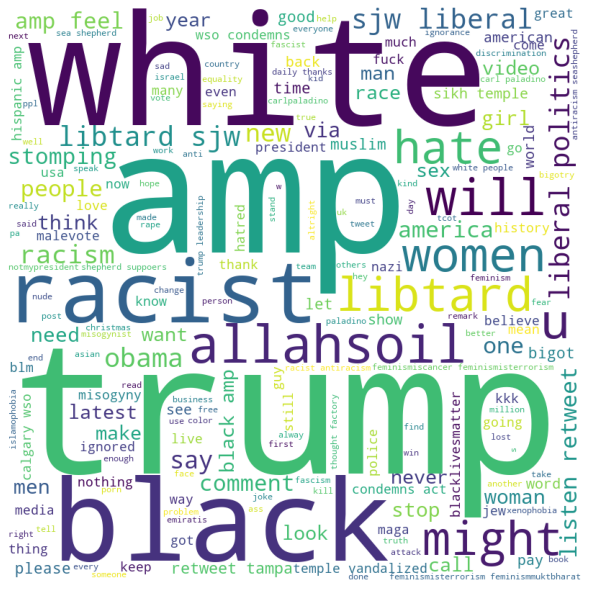

In [9]:
comment_words = ''
stopwords = set(STOPWORDS)

for tokens in df1.tokens:

    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

The difference in words most used are clear as day. The word cloud for the non-hate speech tweets are filled with compassionate and positive words like "love", "happy", "friend", "thankful", and so on. On the other hand, hate speech tweets are filled with polarizing and antagonistic words like "black", "white", "trump", "women", "libtard", and "hate".

While "black", "white", "trump", and "women" are not necessarily offensive words, the way they are probably used in these tweets are most likely antagonistic as other words such as "libtard", "sjw", "hate", and "feminismiscancer" are used alongside them.

So what we would expect to see from the classifier is that it will consider tweets that mention race at all as well as use antagonistic language as hate speech.

# CLASSIFIER

Split the dataframe into training and test data

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train, test = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=619
)

In [12]:
train

,id,label,tweet,tokens
15361,15362,0,@user knossos &amp; akrotiri not included bec...,"[knossos, amp, akrotiri, not, included, becaus..."
19589,19590,1,this is the type of trash trump and paladino ...,"[this, is, the, type, of, trash, trump, and, p..."
13420,13421,0,no worries... the taxpayers have this covered,"[no, worries, the, taxpayers, have, this, cove..."
12559,12560,0,time to officially sta a countdown to when i m...,"[time, to, officially, sta, a, countdown, to, ..."
21377,21378,0,french flag is out at #waterloointernational f...,"[french, flag, is, out, at, waterloointernatio..."
...,...,...,...,...
26657,26658,0,are you on instagram? come join in with #myhap...,"[are, you, on, instagram, come, join, in, with..."
2786,2787,0,#selenagomezforever bull hill climb: you hav...,"[selenagomezforever, bull, hill, climb, you, h..."
5210,5211,0,. my cousin's happy wedding!ðð° #wedding ...,"[my, cousin, happy, wedding, weddingdress, bea..."
2896,2897,0,#friendship bull hill climb: you have to rea...,"[friendship, bull, hill, climb, you, have, to,..."


In [13]:
test

,id,label,tweet,tokens
76,77,0,@user wrapping up #senseaboutmaths @user 6th ...,"[wrapping, up, senseaboutmaths]"
16339,16340,0,i needed money for parking but i only have my ...,"[i, needed, money, for, parking, but, i, only,..."
10607,10608,0,another yr ends with students and i sta planni...,"[another, yr, ends, with, students, and, i, st..."
17700,17701,0,who's a #lucky #girl then? #loveyou â¤ @ pa...,"[who, a, lucky, girl, then, loveyou, paris, fr..."
12823,12824,0,@user @user @user murdo...can you confirm the ...,"[murdo, can, you, confirm, the, original, date..."
...,...,...,...,...
21212,21213,0,small strawberry delicious ððð #sunda...,"[small, strawberry, delicious, sunday, morning..."
1082,1083,0,awake. neighbours alarm clock beeping for last...,"[awake, neighbors, alarm, clock, beeping, for,..."
30672,30673,0,runway lights almost brighter than sunset now ...,"[runway, lights, almost, brighter, than, sunse..."
13720,13721,0,do what makes you !ðð,"[do, what, makes, you]"


Run the classifier

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

In [15]:
sgd = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
sgd.fit(train["tokens"], train["label"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["label"], predicted))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5945
           1       0.83      0.58      0.69       448

    accuracy                           0.96      6393
   macro avg       0.90      0.79      0.83      6393
weighted avg       0.96      0.96      0.96      6393



This is a pretty good result for a classifier we made no changes to. With an macro average f1-score of 0.83, the SGD classifier is pretty good at classifying our tweets overall. It has no problem classifying the non-hate speech as non-hate speech, but it does have some trouble classifying the hate speech as hate speech.

You would think it would be easy to classify hate speech right? As we assumed earlier that hate speech would probably be characterized as involving hate speech and antagonistic language. Let's use error analysis to see what went wrong.

# ERROR ANALYSIS

With error analysis we can see how well the classifier did when working with our dataset.

In [16]:
import cloudpickle
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix

In [17]:
cloudpickle.dump(sgd, open("sgd.model", "wb"))

In [18]:
sgd = cloudpickle.load(open("sgd.model", "rb"))

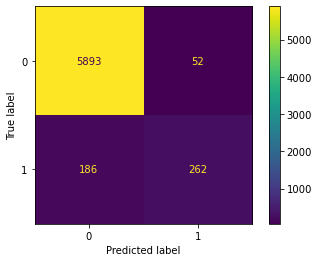

In [19]:
plot_confusion_matrix(sgd, test["tokens"], test["label"])

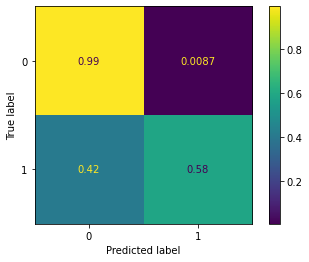

In [20]:
plot_confusion_matrix(sgd, test["tokens"], test["label"], normalize='true')

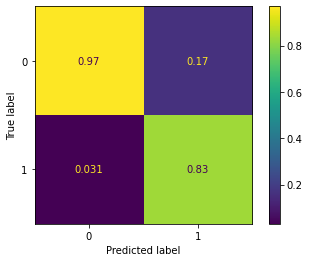

In [21]:
plot_confusion_matrix(sgd, test["tokens"], test["label"], normalize='pred')

So we can see that 43% or 193 out of 448 of the tweets intially labeled as hate speech are being predicted by the classifier as non-hate speech. And from the graph normalized by predicted labels, we can see that 14% of the tweets predicted as hate speech, were initially labeled as non-hate speech. So what's going on here?

### Some tweets that are labeled as non-hate speech but predicted as hate speech:

In [22]:
err0pred1 = test[(test['label']==0)&(predicted==1)]
len(err0pred1)

52

In [23]:
err0pred1['tweet'].iloc[0]

"@user dawn doesn't know what being a real friend is, &amp; she's a grown ass woman.   #notconcernedforanyone #gossipwhore"

In [24]:
err0pred1['tweet'].iloc[1]

'itâ\x80\x99s wonderful living in a lifetime that an african american became president &amp; next we may have our 1st woman president   #imwithher'

In [25]:
err0pred1['tweet'].iloc[2]

' â\x86\x9d #japan foreign investment in japan stocks increased to Â¥128.3b in june 10 from previous Â¥-175.3b   #blog #sâ\x80¦'

Well it seems that some of the non-hate speech tweets are being misclassified as hate speech since they mention race, gender, and trump.

### Some tweets that are labeled as hate speech but predicted as non-hate speech:

In [26]:
err1pred0 = test[(test['label']==1)&(predicted==0)]
len(err1pred0)

186

In [27]:
err1pred0['tweet'].iloc[0]

"@user #stlouis still needs help. @user thinks he's survived. we need to get him out of office, asap. #fergusonâ\x80¦ "

In [28]:
err1pred0['tweet'].iloc[3]

'that is why  is systemic, rather than just humanity being human. it is power and reinforced each minute!'

In [29]:
err1pred0['tweet'].iloc[5]

'@user #carlpalladino makes  comments about #michelleobama.  '

After reading some of the misclassified tweets, we could come to the conclusion that the classifier seems to assume that whenever words related to race, gender, or trump are involved, it must be a hate speech tweet. For example, some of the non-hate speech tweets classified as hate speech involve words like "woman", "trump", and "white" which are all words that showed up in the hate speech word cloud. Whereas the language used in the tweets labeled as hate speech but classified as non-hate speech seems pretty neutral and sometimes positive.

From the hate speech tweets that were misclassified, we might also assume that when the data was created, the people labeling the tweets may have made some errors in their labeling.

# SENTIMENT ANALYSIS

Let's use sentiment analysis to see how positive or negative the language used in both categories can be. We would expect non-hate speech to have a wide range for the vader score as we know language can be positive and negative without the use of hate speech. And we would expect hate speech language to be generally negative right?

Run sentiment analysis on the train and test data

In [30]:
from sklearn.metrics import classification_report, accuracy_score

In [31]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [32]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [33]:
analyzer = SentimentIntensityAnalyzer()

In [34]:
import multiprocessing as mp

In [35]:
def get_compound(text):
    return analyzer.polarity_scores(text)['compound']

with mp.Pool() as p:
    train['vader'] = list(p.imap(get_compound, tqdm(train['tweet']), chunksize=500))
    test['vader'] = list(p.imap(get_compound, tqdm(test['tweet']), chunksize=500))

  0%|          | 0/25569 [00:00<?, ?it/s]

<ipython-input-35-0f8f0cc8ef32>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['vader'] = list(p.imap(get_compound, tqdm(train['tweet']), chunksize=500))


  0%|          | 0/6393 [00:00<?, ?it/s]

<ipython-input-35-0f8f0cc8ef32>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['vader'] = list(p.imap(get_compound, tqdm(test['tweet']), chunksize=500))


Create boxplots to show range of vader scores for each label

In [36]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'VADER composite')

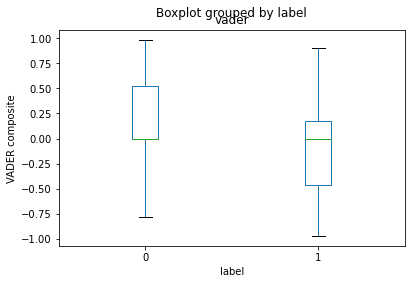

In [37]:
train.boxplot('vader', by='label', grid=False, showfliers=False)
plt.ylabel('VADER composite')

We know from the previous assignment that vader sentiment analysis isn't so good at setting a ceiling for the vader scores but is good at setting a floor. From these new box plots, we can see that the non-hate speech tweets has a higher IQR than the hate speech tweets but has a similarly large range. With this knowledge we can infer that the vader scores for both labels vary almost equally as wide as each other but non-hate speech is generally more positive. This could mean that tweets seem equally as positive or negative whether or not hate speech is involved.

For example, some tweets could be spreading a positive message while using some derogatory words, as people can be nice and just as ignorant. From this we can conclude that you can indeed be negative without the use of hate speech as well as be positive sounding with hate speech.

# Conclusion/Final Thoughts

We can see now why our tools have some problems classifying some hate speech as hate speech and problems with mistakenly classifying non-hate speech as hate speech. This is an issue with real world social media bots meant to tackle these situations as Twitter and other platforms don't want to ban users or flag them as racist and/or bigoted for a post that a bot thought was hate speech when it actually wasn't. Some hate speech tweets use language that comes off as neutral or even positive. This happens because racism, misogyny, misandry, transphobia doesn't have to be blatant in language. These ideas can be subtle in their delivery as people who might have these ideas could just be ignorant and not necessarily hateful.

So from this project we can conclude that hate speech is not a simple task to perform. The bots that perform hate speech detection need a lot of tweaking to accurately identify instances of hate speech as well as ignore non-hate speech when they use words involving race, gender, etc.